In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.transpiler.passes import Depth
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate, Parameter


import azure.quantum
from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider
import numpy as np

import sys
import os

sys.path.append(os.path.abspath("..\\.."))
from objects.FiveQbPerfectCode import FiveQbPerfectCodeCircuit
from functions import *


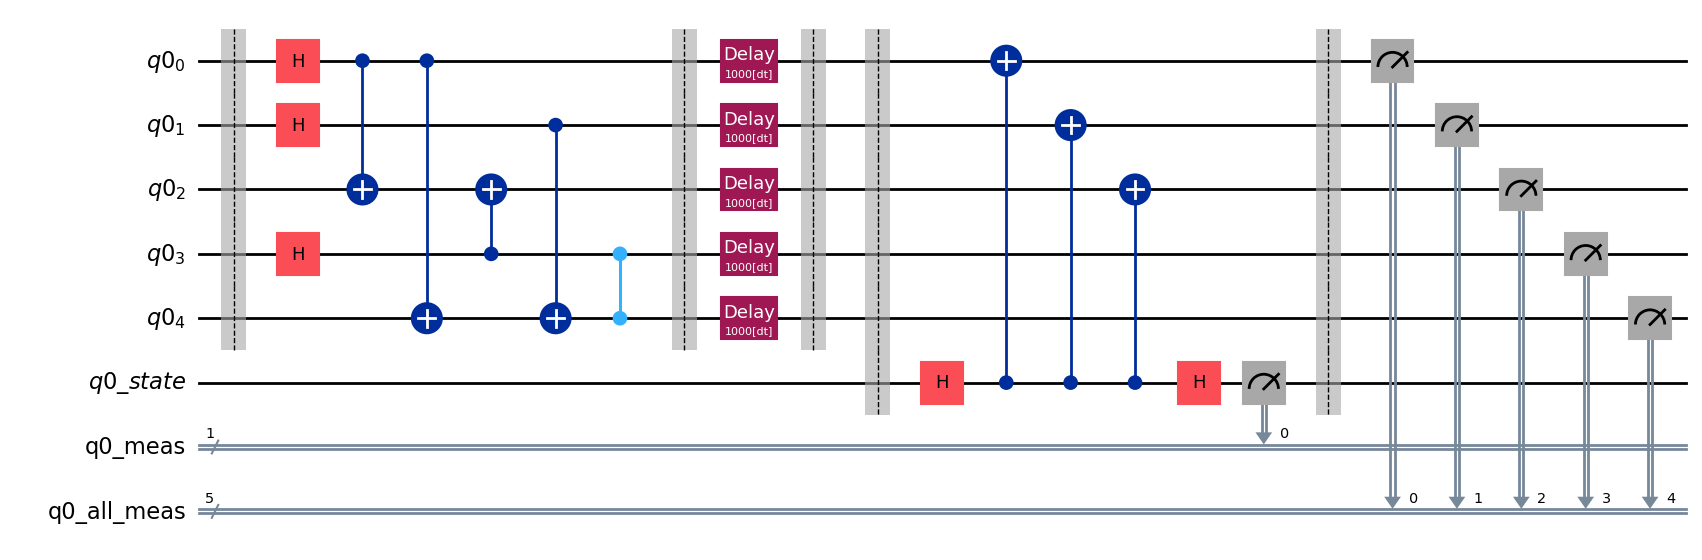

In [7]:

def load_circuit(delay):
    qc = FiveQbPerfectCodeCircuit(1)

    qc.encode(type='0')
    # qc.x() # activar para probar el estado 1 logico
    # qc.h()
    qc.delay(delay)
    
    qc.logical_measure(basis='Z')
    qc.measure_all()

    return qc

qc = load_circuit(1000)
qc.draw('mpl')



In [11]:
# Acceso a IONQ
workspace = Workspace(
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)



## Backend

In [12]:
# backend_name = "ionq.qpu.aria-1"
backend_name = "ionq.simulator"
backend = provider.get_backend(backend_name)


In [13]:


sampler = SamplerV2(backend)
shots = 100

option_params = {
    # "shots": shots,
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}
backend.options.update_options(**option_params)

# Transpilar el circuito
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = transpile(qc.physical_circuit, backend, optimization_level=1)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
print(f"Estimated Cost: {backend.estimate_cost(isa_circuit, shots=shots).estimated_total}")
# isa_circuit.draw('mpl') # Imprimimos el circuito transpilado

Circuit Depth: 13
Transpiled Circuit Depth: 13
Estimated Cost: 0.0


In [14]:
# gpi
phi = Parameter('φ')
gpi_matrix = np.array([[0, np.exp(-1j * 2*np.pi * phi)],
                       [np.exp(1j * 2*np.pi * phi), 0]])
gpi_gate = Gate(name='gpi', num_qubits=1, params=[phi])

# gpi2
phi = Parameter('φ')
gpi2_matrix = np.array([[1, -1j * np.exp(-1j * 2*np.pi * phi)],
                        [-1j * np.exp(1j * 2*np.pi * phi), 1]]) / np.sqrt(2)
gpi2_gate = Gate(name='gpi2', num_qubits=1, params=[phi])

# virtual Z
theta = Parameter('θ')
vz_matrix = np.array([[np.exp(-1j * np.pi * theta), 0],
                      [0, np.exp(1j * np.pi * theta)]])
vz_gate = Gate(name='vz', num_qubits=1, params=[theta])

# fully entangling MS
phi_0 = Parameter('φ₀')
phi_1 = Parameter('φ₁')
f_ms_matrix = np.array([[1, 0, 0, -1j * np.exp(-1j * 2*np.pi * (phi_0 + phi_1))],
                        [0, 1, -1j * np.exp(-1j * 2*np.pi * (phi_0 - phi_1)), 0],
                        [0, -1j * np.exp(1j * 2*np.pi * (phi_0 - phi_1)), 1, 0],
                        [-1j * np.exp(1j * 2*np.pi * (phi_0 + phi_1)), 0, 0, 1] ]) / np.sqrt(2)
f_ms_gate = Gate(name='f_ms', num_qubits=2, params=[phi_0, phi_1])

# partially entangling MS
phi_0 = Parameter('φ₀')
phi_1 = Parameter('φ₁')
theta = Parameter('θ')
p_ms_matrix = np.array([[np.cos(np.pi*theta), 0, 0, -1j * np.exp(-1j * 2*np.pi * (phi_0 + phi_1)) * np.sin(np.pi*theta)],
                        [0, np.cos(np.pi*theta), -1j * np.exp(-1j * 2*np.pi * (phi_0 - phi_1)) * np.sin(np.pi*theta), 0],
                        [0, -1j * np.exp(1j * 2*np.pi * (phi_0 - phi_1)) * np.sin(np.pi*theta), np.cos(np.pi*theta), 0],
                        [-1j * np.exp(1j * 2*np.pi * (phi_0 + phi_1)) * np.sin(np.pi*theta), 0, 0, np.cos(np.pi*theta)]])
p_ms_gate = Gate(name='p_ms', num_qubits=2, params=[phi_0, phi_1, theta])



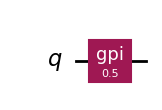

In [15]:
from qiskit.circuit.library import RXGate

test = QuantumCircuit(1)
test.append(gpi_gate, [0])

test = test.assign_parameters({gpi_gate.params[0]: 0.5})

test.draw('mpl')

In [17]:

gate_set = ["gpi", "gpi2", "vz", "f_ms", "p_ms"]
# gate_set = backend.configuration().basis_gates.append("gpi")

estimated_isa_circuit = transpile(qc.physical_circuit, backend=backend, basis_gates=gate_set)
print(f"Transpiled Circuit Depth: {estimated_isa_circuit.depth()}")
estimated_isa_circuit.draw('mpl')

TranspilerError: 'Unable to translate the operations in the circuit: ["barrier", "cz", "h", "delay", "barrier", "measure", "cx"] to the backend\'s (or manually specified) target basis: {"if_else", "measure", "vz", "while_loop", "switch_case", "store", "for_loop", "gpi", "delay", "p_ms", "barrier", "reset", "gpi2", "snapshot", "f_ms"}. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes. BasisTranslator#translation-errors'

In [14]:
# def get_layout(circuit, qb_len=1):
#     layout = circuit._layout.initial_layout.get_virtual_bits()
#     print(layout)
#     keys = [layout[i] for i in layout]
#     return keys[:qb_len]

# print(get_layout(isa_circuit, qb_len=5))


In [15]:
# t_array = [80_000, 160_000, 320_000]
t_array = [100_000]
# t_array = range(0, 21)
# t_array = [t*10_000 for t in t_array]

circuits = []

for t in t_array:

    qc = load_circuit(t)

    # isa_circuit = get_transpile(qc.physical_circuit, backend, iterations=10, scheduling_method="asap", optimization_level=3)
    circuits.append(transpile(qc.physical_circuit, backend, optimization_level=3))

    print(f"Circuit Depth: {circuits[-1].depth()}")
    circuits[-1].draw(output='mpl')
    # print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
    # print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")
    # print(get_layout(circuits[-1], qb_len=5))
    print('\n')
    # c.draw(output='mpl')

Circuit Depth: 13




In [16]:
def sampler_simulation(circuit, samples):

    from qiskit_aer.primitives import SamplerV2

    exact_sampler = SamplerV2()

    # Transpilamos el circuito
    pass_manager = generate_preset_pass_manager(3, AerSimulator())

    # Corremos el circuito:
    pub = (pass_manager.run(circuit), None, samples) # Notemos que tambien funciona si le pasamos el circuito qc
    job = exact_sampler.run([pub])

    result = job.result()
    pub_result = result[0]

    for lq in qc.qubits:

        # resultados de medir estado logico
        state = lq.qb_measure
        print(f"  {state.name}: {pub_result.data[state.name].get_counts()}")

        state = lq.all_measures
        print(f"  {state.name}: {pub_result.data[state.name].get_counts()}")


sampler_simulation(qc.physical_circuit, 100)

        


  q0_meas: {'0': 100}
  q0_all_meas: {'11110': 12, '00111': 13, '10010': 9, '01011': 12, '11001': 13, '01100': 16, '00000': 10, '10101': 15}


In [22]:
# # Correr el circuito en el backend y obtener resultados
# job = backend.run(circuits, shots = shots)
# pub_result = job.result()
# job_id = pub_result.job_id
# # print(*[r.data for r in pub_result.results], sep='\n')


........

In [21]:
states = [bin(i)[2:].zfill(5) for i in range(2**5)]

all_measures_results = []
logical_results = []
for result in pub_result.results:
    counts = result.data.counts
    
    all_res = {}
    log_res = {}

    for s in states:
        s_inv = s[::-1]
        # res[k] = meas[k_inv] if k_inv in meas else 0
        all_res[s] = int(np.sum([counts[output] for output in counts if output.split(' ')[0] == s_inv]))
    
    for s in ["0","1"]:
        log_res[s] = int(np.sum([counts[output] for output in counts if output.split(' ')[1] == s]))

    all_measures_results.append(all_res)
    logical_results.append(log_res)




In [56]:
print(all_measures_results)
print(logical_results)

[{'00000': 12, '00001': 0, '00010': 0, '00011': 0, '00100': 0, '00101': 0, '00110': 12, '00111': 0, '01000': 0, '01001': 12, '01010': 0, '01011': 0, '01100': 0, '01101': 0, '01110': 0, '01111': 12, '10000': 0, '10001': 0, '10010': 0, '10011': 12, '10100': 0, '10101': 12, '10110': 0, '10111': 0, '11000': 0, '11001': 0, '11010': 12, '11011': 0, '11100': 12, '11101': 0, '11110': 0, '11111': 0}]
[{'0': 96, '1': 0}]


In [53]:

delays = [round(t*dt/1000) for t in t_array]
# print(f" delay\t| 111\t| 000\t| other states")
print(f" delay (μs)", *[f"{s}" for s in states], sep='\t ')
print("----------------------------------------------------------------------------------")
for i in range(len(t_array)):

    # print(f" > {meas}, error rate: {shots - meas['1']}%")
    print(f" {delays[i]}\t", *[all_measures_results[i][s] for s in states], sep='\t ')

 delay (μs)	 00000	 00001	 00010	 00011	 00100	 00101	 00110	 00111	 01000	 01001	 01010	 01011	 01100	 01101	 01110	 01111	 10000	 10001	 10010	 10011	 10100	 10101	 10110	 10111	 11000	 11001	 11010	 11011	 11100	 11101	 11110	 11111
----------------------------------------------------------------------------------
 0		 9	 2	 0	 0	 0	 0	 9	 0	 2	 15	 0	 1	 0	 0	 1	 9	 2	 0	 0	 15	 0	 7	 0	 0	 0	 0	 15	 0	 13	 0	 0	 0
 5		 10	 1	 2	 1	 3	 1	 10	 2	 6	 1	 0	 0	 3	 1	 6	 4	 0	 3	 2	 12	 0	 10	 0	 3	 0	 0	 0	 10	 3	 5	 0	 1
 10		 7	 1	 0	 0	 0	 0	 6	 3	 1	 16	 0	 0	 0	 1	 2	 16	 0	 2	 1	 10	 0	 7	 0	 0	 6	 0	 10	 0	 10	 0	 0	 1
 15		 16	 0	 4	 2	 7	 2	 16	 0	 5	 0	 2	 2	 0	 0	 5	 2	 0	 3	 2	 8	 1	 4	 0	 0	 1	 2	 4	 2	 2	 8	 0	 0
 20		 13	 4	 5	 1	 2	 3	 13	 0	 5	 3	 1	 1	 2	 0	 1	 1	 2	 3	 1	 6	 0	 13	 0	 0	 0	 3	 2	 10	 0	 3	 0	 2
 25		 12	 3	 3	 1	 3	 0	 12	 1	 10	 3	 1	 1	 0	 2	 2	 3	 1	 3	 1	 11	 2	 12	 0	 0	 1	 4	 0	 2	 2	 3	 0	 1
 30		 6	 3	 2	 0	 1	 2	 7	 4	 1	 10	 3	 4	 0	 1	 5	 

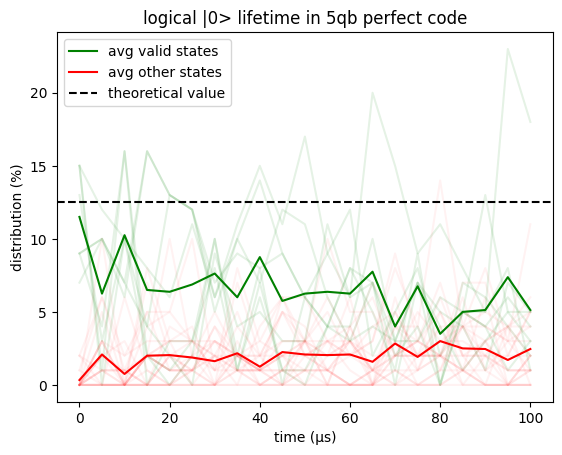

In [54]:
import matplotlib.pyplot as plt
import math

valid_states = [
    '00000',
    '11100',
    '11010',
    '00110',
    '01001',
    '10101',
    '10011',
    '01111'
]

# possible_valid_states = []
# x = [math.log(d) for d in delays]
x = delays
y = {}
for s in states:
    y[s] = [r[s] for r in all_measures_results]
    
    # if y[s][0] > 5:
        # possible_valid_states.append(s)
    if s in valid_states:
        # if s == '00000':
        #     plt.plot(x, y[s], alpha=0.2, color='black')
        #     continue
        plt.plot(x, y[s], alpha=0.1, color='green')
    else:
        plt.plot(x, y[s], alpha=0.05, color='red')


plt.plot(x, [sum([r[s] for s in valid_states])/8 for r in all_measures_results], label='avg valid states', color='green')
# plt.plot(x, [sum([r[s] for s in possible_valid_states if s != '00000'])/7 for r in results], label='avg valid states', color='black')
plt.plot(x, [sum([r[s] for s in states if s not in valid_states])/24 for r in all_measures_results], label='avg other states', color='red')

plt.axhline(y=100/8, color='k', linestyle='--', label='theoretical value')
    
# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('distribution (%)')
plt.title('logical |0> lifetime in 5qb perfect code')
plt.legend()

# Display the plot
plt.show()

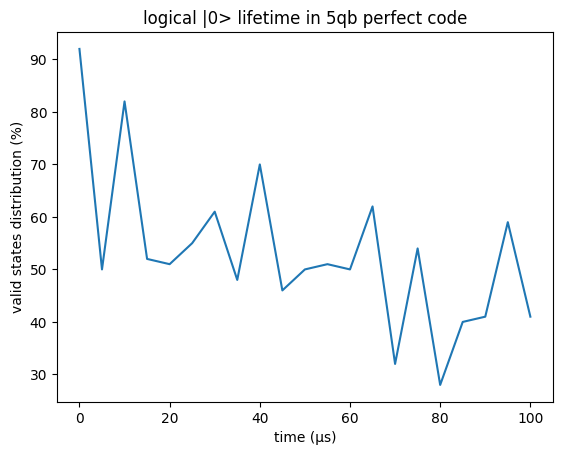

In [55]:
plt.plot(x, [sum([r[s] for s in valid_states]) for r in all_measures_results], label='valid states')

# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('valid states distribution (%)')
plt.title('logical |0> lifetime in 5qb perfect code')
# plt.legend()

# Display the plot
plt.show()